In [56]:
"""
*BM3D算法简单实现,主要程序部分
"""
import cv2
import math
import numpy 
import matplotlib.pyplot as plt

# Parameters initialization
sigma = 25
Threshold_Hard3D = 2.7 * sigma  # Threshold for Hard Thresholding

Step1_Blk_Size = 4  # block_Size即块的大小
Step1_Blk_Step = 1  # Rather than sliding by one pixel to every next reference block, use a step of Nstep pixels in both horizontal and vertical directions.
Step1_Search_Step = 1  # 块的搜索step
First_Match_threshold = 125 * Step1_Blk_Size ** 2  # 用于计算block之间相似度的阈值
Step1_max_matched_cnt = 16  # 组最大匹配的块数
Step1_Search_Window = 15  # Search for candidate matching blocks in a local neighborhood of restricted size NS*NS centered

Step2_Blk_Size = 4
Step2_Blk_Step = 1
Step2_Search_Step = 1
Second_Match_threshold = 220. / 16 * Step2_Blk_Size ** 2  # 用于计算block之间相似度的阈值
Step2_max_matched_cnt = 32
Step2_Search_Window = 25

Beta_Kaiser = 1.5


def init(img, _blk_size, _Beta_Kaiser):
    """该函数用于初始化，返回用于记录过滤后图像以及权重的数组,还有构造凯撒窗"""
    m_shape = img.shape
    m_img = numpy.matrix(numpy.zeros(m_shape, dtype=float))
    m_wight = numpy.matrix(numpy.zeros(m_shape, dtype=float))

    # 窗函数(window function)是一种除在给定区间之外取值均为0的实函数
    K = numpy.matrix(numpy.kaiser(_blk_size, _Beta_Kaiser))
    m_Kaiser = numpy.array(K.T * K)  # 构造一个凯撒窗
    # 窗函数：https://zh.wikipedia.org/wiki/窗函数#Kaiser窗

    return m_img, m_wight, m_Kaiser


def Locate_blk(i, j, blk_step, block_Size, width, height):
    '''该函数用于保证当前的blk不超出图像范围'''
    if i * blk_step + block_Size < width:
        point_x = i * blk_step
    else:
        point_x = width - block_Size

    if j * blk_step + block_Size < height:
        point_y = j * blk_step
    else:
        point_y = height - block_Size

    m_blockPoint = numpy.array((point_x, point_y), dtype=int)  # 当前参考图像的顶点

    return m_blockPoint


def Define_SearchWindow(_noisyImg, _BlockPoint, _WindowSize, Blk_Size):
    """
    该函数利用block的左上顶点的位置返回一个二元组（x,y）
    用以界定_Search_Window左上角顶点坐标

    """
    point_x = _BlockPoint[0]  # 当前坐标
    point_y = _BlockPoint[1]  # 当前坐标

    # 获得SearchWindow四个顶点的坐标
    LX = point_x + Blk_Size / 2 - _WindowSize / 2  # 左上x
    LY = point_y + Blk_Size / 2 - _WindowSize / 2  # 左上y
    RX = LX + _WindowSize  # 右下x
    RY = LY + _WindowSize  # 右下y

    # 判断一下是否越界
    if LX < 0:
        LX = 0
    elif RX > _noisyImg.shape[0]:
        LX = _noisyImg.shape[0] - _WindowSize
    if LY < 0:
        LY = 0
    elif RY > _noisyImg.shape[0]:
        LY = _noisyImg.shape[0] - _WindowSize

    return numpy.array((LX, LY), dtype=int)


def Step1_fast_match(_noisyImg, _BlockPoint):
    """快速匹配"""
    '''
    *返回邻域内寻找和当前_block相似度最高的几个block,返回的数组中包含本身
    *_noisyImg:噪声图像
    *_BlockPoint:当前block的坐标及大小
    '''
    (present_x, present_y) = _BlockPoint  # 当前坐标
    Blk_Size = Step1_Blk_Size
    Search_Step = Step1_Search_Step
    Threshold = First_Match_threshold
    max_matched = Step1_max_matched_cnt
    Window_size = Step1_Search_Window

    blk_positions = numpy.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
    Final_similar_blocks = numpy.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)  # 用于保存最后结果

    img = _noisyImg[present_x: present_x + Blk_Size, present_y: present_y + Blk_Size]
    dct_img = cv2.dct(img.astype(numpy.float64))  # 对目标作block作二维余弦变换

    Final_similar_blocks[0, :, :] = dct_img  # 保存变换后的目标块
    blk_positions[0, :] = _BlockPoint

    Window_location = Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
    blk_num = (Window_size - Blk_Size) / Search_Step  # 确定最多可以找到多少相似blk
    blk_num = int(blk_num)
    (present_x, present_y) = Window_location

    similar_blocks = numpy.zeros((blk_num ** 2, Blk_Size, Blk_Size), dtype=float)
    m_Blkpositions = numpy.zeros((blk_num ** 2, 2), dtype=int)
    Distances = numpy.zeros(blk_num ** 2, dtype=float)  # 记录各个blk与它的相似度

    # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
    matched_cnt = 0
    for i in range(blk_num):
        for j in range(blk_num):
            tem_img = _noisyImg[present_x: present_x + Blk_Size, present_y: present_y + Blk_Size]
            dct_Tem_img = cv2.dct(tem_img.astype(numpy.float64))
            # 先对块进行dct变换再求l2-norm，寻找相似块，降低噪点的干扰
            m_Distance = numpy.linalg.norm((dct_img - dct_Tem_img)) ** 2 / (Blk_Size ** 2)

            # 下面记录数据自动不考虑自身(因为已经记录)
            if m_Distance < Threshold and m_Distance > 0:  # 说明找到了一块符合要求的
                similar_blocks[matched_cnt, :, :] = dct_Tem_img
                m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                Distances[matched_cnt] = m_Distance
                matched_cnt += 1
            present_y += Search_Step
        present_x += Search_Step
        present_y = Window_location[1]  # 搜索窗的行
    # 取前matched_cnt个块
    Distances = Distances[:matched_cnt]
    # 对distance进行排序，找到对应顺序的序号
    # numpy.argsort() 的用法：
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
    Sort = Distances.argsort()

    # 统计一下找到了多少相似的blk
    if matched_cnt < max_matched:
        Count = matched_cnt + 1
    else:
        Count = max_matched
    # 将前matched_cnt个块放入Final_similar_blocks，左上坐标信息保存在lk_positions
    if Count > 0:
        for i in range(1, Count):
            Final_similar_blocks[i, :, :] = similar_blocks[Sort[i - 1], :, :]
            blk_positions[i, :] = m_Blkpositions[Sort[i - 1], :]
    return Final_similar_blocks, blk_positions, Count


def Step1_3DFiltering(_similar_blocks):
    '''
    *3D变换及滤波处理
    *_similar_blocks:相似的一组block,这里已经是频域的表示
    *要将_similar_blocks第三维依次取出,然在频域用阈值滤波之后,再作反变换
    '''

    statis_nonzero = 0  # 非零元素个数
    m_Shape = _similar_blocks.shape

    # 下面这一段代码很耗时
    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            # print _similar_blocks[:, i, j], type(_similar_blocks[:, i, j])
            tem_Vct_Trans = cv2.dct(_similar_blocks[:, i, j])
            # 硬阈值变换，去掉较小的频率成分
            tem_Vct_Trans[numpy.abs(tem_Vct_Trans[:]) < Threshold_Hard3D] = 0.
            statis_nonzero += tem_Vct_Trans.nonzero()[0].size
            _similar_blocks[:, i, j] = cv2.idct(tem_Vct_Trans)[0]
    return _similar_blocks, statis_nonzero


def Aggregation_hardthreshold(_similar_blocks, blk_positions, m_basic_img, m_wight_img, _nonzero_num, Count, Kaiser):
    '''
    *对3D变换及滤波后输出的stack进行加权累加,得到初步滤波的图片
    *_similar_blocks:相似的一组block,这里是频域的表示
    *对这些块，用非零项的权重乘以凯撒窗之后再分别放回原位
    '''
    _shape = _similar_blocks.shape
    if _nonzero_num < 1:
        _nonzero_num = 1
    block_wight = (1. / (sigma ** 2 * _nonzero_num)) * Kaiser
    for i in range(Count):
        point = blk_positions[i, :]
        tem_img = block_wight * cv2.idct(_similar_blocks[i, :, :])
        m_basic_img[point[0]:point[0] + _shape[1], point[1]:point[1] + _shape[2]] += tem_img
        m_wight_img[point[0]:point[0] + _shape[1], point[1]:point[1] + _shape[2]] += block_wight


def BM3D_1st_step(_noisyImg):
    """第一步,基本去噪"""
    # 初始化一些参数：
    (width, height) = _noisyImg.shape  # width = row, height = col
    block_Size = Step1_Blk_Size  # 块大小
    blk_step = Step1_Blk_Step  # N块步长滑动
    # 根据步长确定搜索的次数
    Width_num = (width - block_Size) / blk_step
    Height_num = (height - block_Size) / blk_step

    # 初始化几个数组
    # 空图像、空权重表、凯撒窗
    Basic_img, m_Wight, m_Kaiser = init(_noisyImg, Step1_Blk_Size, Beta_Kaiser)

    # 开始逐block的处理,+2是为了避免边缘上不够
    for i in range(int(Width_num + 2)):
        for j in range(int(Height_num + 2)):
            # m_blockPoint当前参考图像的左上角顶点
            m_blockPoint = Locate_blk(i, j, blk_step, block_Size, width, height)  # 该函数用于保证当前的blk不超出图像范围
            Similar_Blks, Positions, Count = Step1_fast_match(_noisyImg, m_blockPoint)  # 相似块集合、相似块位置、相似块数量
            Similar_Blks, statis_nonzero = Step1_3DFiltering(Similar_Blks)  # 协同过滤后的相似块集合、非零项数量
            Aggregation_hardthreshold(Similar_Blks, Positions, Basic_img, m_Wight, statis_nonzero, Count, m_Kaiser)
    Basic_img[:, :] /= m_Wight[:, :]
    basic = numpy.matrix(Basic_img, dtype=int)
    basic.astype(numpy.uint8)

    return basic


def Step2_fast_match(_Basic_img, _noisyImg, _BlockPoint):
    '''
    *快速匹配算法,返回邻域内寻找和当前_block相似度最高的几个block,要同时返回basicImg和IMG
    *_Basic_img: 基础去噪之后的图像
    *_noisyImg:噪声图像
    *_BlockPoint:当前block的坐标及大小
    '''
    (present_x, present_y) = _BlockPoint  # 当前坐标
    Blk_Size = Step2_Blk_Size
    Threshold = Second_Match_threshold
    Search_Step = Step2_Search_Step
    max_matched = Step2_max_matched_cnt
    Window_size = Step2_Search_Window

    blk_positions = numpy.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
    Final_similar_blocks = numpy.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)
    Final_noisy_blocks = numpy.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)

    img = _Basic_img[present_x: present_x + Blk_Size, present_y: present_y + Blk_Size]
    dct_img = cv2.dct(img.astype(numpy.float32))  # 对目标作block作二维余弦变换
    Final_similar_blocks[0, :, :] = dct_img

    n_img = _noisyImg[present_x: present_x + Blk_Size, present_y: present_y + Blk_Size]
    dct_n_img = cv2.dct(n_img.astype(numpy.float32))  # 对目标作block作二维余弦变换
    Final_noisy_blocks[0, :, :] = dct_n_img

    blk_positions[0, :] = _BlockPoint

    Window_location = Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
    blk_num = (Window_size - Blk_Size) / Search_Step  # 确定最多可以找到多少相似blk
    blk_num = int(blk_num)
    (present_x, present_y) = Window_location

    similar_blocks = numpy.zeros((blk_num ** 2, Blk_Size, Blk_Size), dtype=float)
    m_Blkpositions = numpy.zeros((blk_num ** 2, 2), dtype=int)
    Distances = numpy.zeros(blk_num ** 2, dtype=float)  # 记录各个blk与它的相似度

    # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
    matched_cnt = 0
    for i in range(blk_num):
        for j in range(blk_num):
            tem_img = _Basic_img[present_x: present_x + Blk_Size, present_y: present_y + Blk_Size]
            # dct_Tem_img = cv2.dct(tem_img.astype(numpy.float32))
            # m_Distance = numpy.linalg.norm((dct_img - dct_Tem_img)) ** 2 / (Blk_Size ** 2)

            m_Distance = numpy.linalg.norm((img - tem_img)) ** 2 / (Blk_Size ** 2)
            # 下面记录数据自动不考虑自身(因为已经记录)
            if m_Distance < Threshold and m_Distance > 0:
                dct_Tem_img = cv2.dct(tem_img.astype(numpy.float32))
                similar_blocks[matched_cnt, :, :] = dct_Tem_img
                m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                Distances[matched_cnt] = m_Distance
                matched_cnt += 1
            present_y += Search_Step
        present_x += Search_Step
        present_y = Window_location[1]
    Distances = Distances[:matched_cnt]
    Sort = Distances.argsort()

    # 统计一下找到了多少相似的blk
    if matched_cnt < max_matched:
        Count = matched_cnt + 1
    else:
        Count = max_matched

    # nosiy图像的3D Stack，利用第一步的Basic估计结果来构造
    if Count > 0:
        for i in range(1, Count):
            Final_similar_blocks[i, :, :] = similar_blocks[Sort[i - 1], :, :]
            blk_positions[i, :] = m_Blkpositions[Sort[i - 1], :]

            (present_x, present_y) = m_Blkpositions[Sort[i - 1], :]
            n_img = _noisyImg[present_x: present_x + Blk_Size, present_y: present_y + Blk_Size]
            Final_noisy_blocks[i, :, :] = cv2.dct(n_img.astype(numpy.float64))

    return Final_similar_blocks, Final_noisy_blocks, blk_positions, Count


def Step2_3DFiltering(_Similar_Bscs, _Similar_Imgs):
    '''
    *3D维纳变换的协同滤波
    *_similar_blocks:相似的一组block,这里是频域的表示
    *要将_similar_blocks第三维依次取出,然后作dct,在频域进行维纳滤波之后,再作反变换
    *返回的Wiener_wight用于后面Aggregation
    '''
    m_Shape = _Similar_Bscs.shape
    Wiener_wight = numpy.zeros((m_Shape[1], m_Shape[2]), dtype=float)

    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            tem_vector = _Similar_Bscs[:, i, j]
            tem_Vct_Trans = numpy.matrix(cv2.dct(tem_vector))

            Norm_2 = numpy.float64(tem_Vct_Trans.T * tem_Vct_Trans)
            m_weight = Norm_2 / (Norm_2 + sigma ** 2)
            Wiener_wight[i, j] = m_weight

            #if m_weight != 0: Wiener_wight[i, j] = 1. / (m_weight ** 2 * sigma ** 2)
            # else:
            #     Wiener_wight[i, j] = 10000

            # RES=IDCT(WEIGHT(DCT(NOISE_BLOCK)))
            tem_vector = _Similar_Imgs[:, i, j]
            tem_Vct_Trans = m_weight * cv2.dct(tem_vector)
            _Similar_Bscs[:, i, j] = cv2.idct(tem_Vct_Trans)[0]

    return _Similar_Bscs, Wiener_wight


def Aggregation_Wiener(_Similar_Blks, _Wiener_wight, blk_positions, m_basic_img, m_wight_img, Count, Kaiser):
    '''
    *对3D变换及滤波后输出的stack进行加权累加,得到初步滤波的图片
    *_similar_blocks:相似的一组block,这里是频域的表示
    *对于最后的块，乘以凯撒窗之后再输出
    '''
    _shape = _Similar_Blks.shape
    block_wight = _Wiener_wight * Kaiser

    for i in range(Count):
        point = blk_positions[i, :]
        tem_img = _Wiener_wight * cv2.idct(_Similar_Blks[i, :, :]) * Kaiser
        m_basic_img[point[0]:point[0] + _shape[1], point[1]:point[1] + _shape[2]] += tem_img
        m_wight_img[point[0]:point[0] + _shape[1], point[1]:point[1] + _shape[2]] += block_wight


def BM3D_2nd_step(_basicImg, _noisyImg):
    '''Step 2. 最终的估计: 利用基本的估计，进行改进了的分组以及协同维纳滤波'''
    # 初始化一些参数：
    (width, height) = _noisyImg.shape
    block_Size = Step2_Blk_Size
    blk_step = Step2_Blk_Step
    Width_num = (width - block_Size) / blk_step
    Height_num = (height - block_Size) / blk_step

    # 初始化几个数组
    m_img, m_Wight, m_Kaiser = init(_noisyImg, block_Size, Beta_Kaiser)

    for i in range(int(Width_num + 2)):
        for j in range(int(Height_num + 2)):
            m_blockPoint = Locate_blk(i, j, blk_step, block_Size, width, height)
            Similar_Blks, Similar_Imgs, Positions, Count = Step2_fast_match(_basicImg, _noisyImg, m_blockPoint)
            Similar_Blks, Wiener_wight = Step2_3DFiltering(Similar_Blks, Similar_Imgs)
            Aggregation_Wiener(Similar_Blks, Wiener_wight, Positions, m_img, m_Wight, Count, m_Kaiser)
    m_img[:, :] /= m_Wight[:, :]
    Final = numpy.matrix(m_img, dtype=int)
    Final.astype(numpy.uint8)

    return Final




def PSNR(I,K):
    return 10*(numpy.log((255*255)/((I.astype(numpy.float)-K)**2).mean()))/numpy.log(10)


#显示图片
def plot_img(I):
   
    plt.figure(figsize = [10,8])
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    
    #plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
    plt.imshow(I,cmap = "gray")
    plt.show()
    
 
 

In [57]:
ori = cv2.imread("rick.jpg", cv2.IMREAD_GRAYSCALE)  # 读入图像，cv2.IMREAD_GRAYSCALE:以灰度模式读入图像
sigma = 30
noise_rick = ori + np.random.randn(*ori.shape)*sigma

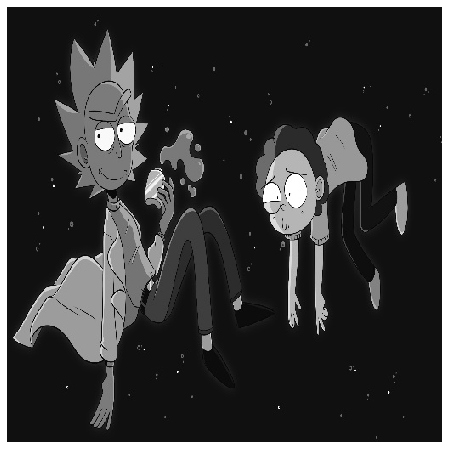

In [58]:
plot_img(ori)

The PSNR After add noise 18.586997


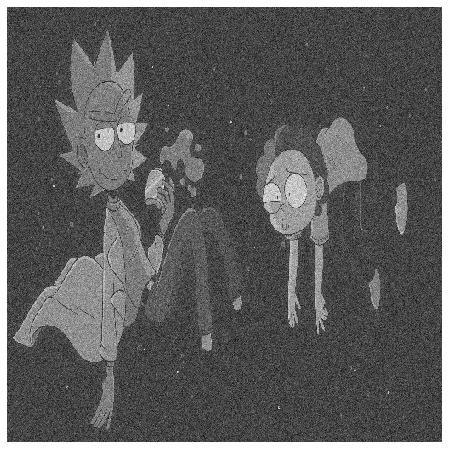

In [59]:
print('The PSNR After add noise %f' % PSNR(ori, noise_rick))
plot_img(noise_rick)

The PSNR between the two img of the First step is 22.919365


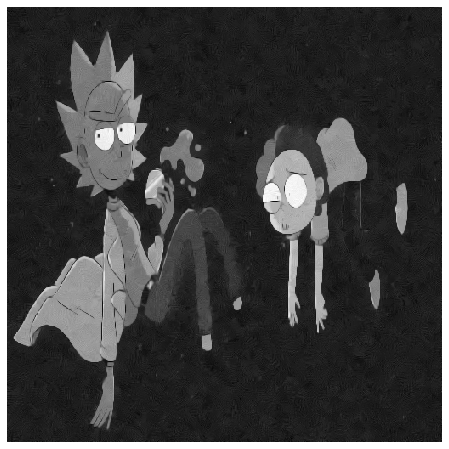

Wall time: 11min 14s


In [60]:
%%time
Basic_img = BM3D_1st_step(noise_rick)
print ("The PSNR between the two img of the First step is %f" % PSNR(ori, Basic_img))
plot_img(Basic_img)

The PSNR between the two img of the Second step is 25.793421


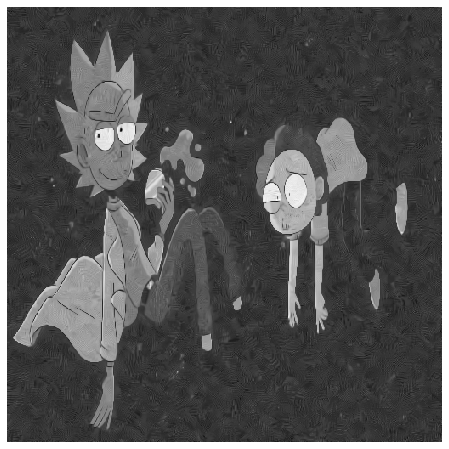

Wall time: 57min 47s


In [61]:
%%time
Final_img = BM3D_2nd_step(Basic_img, noise_rick)
print ("The PSNR between the two img of the Second step is %f" % PSNR(ori, Final_img))
plot_img(Final_img)